# Install

In [ ]:
pip install image # install's PIL, the python image library
# install portaudio is required by pyaudio (http://portaudio.com/docs/v19-doxydocs/tutorial_start.html)
pip install pyaudio # for recording within python. used for audioSearch module
pip install pygame # for realtime MIDI performance in midi.realtime module
# install muscore for viewing and editing music notation (http://www.musescore.org)
# install lilypond for displaying musical scores (http://lilypond.org/) 

# Import

In [546]:
# directory, files management, etc.
import os
from os.path import isfile, join
import glob
from StringIO import StringIO

# arrays, dataframes
import numpy as np
import pandas as pd

# utilities
import random as rand
import time
import matplotlib.pyplot as plt
%matplotlib inline

# audio
import wave
#import pyaudio

# MIR
import essentia
import madmom as mad
import music21 as m21

# neural nets

# Globals

In [547]:
# pitches, notes
NOTES = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
NUM_PITCH_CLASS = len(NOTES)
NUM_MIDI_PITCH = 127               # range of audible sounds
RANGE_PIANO_PITCH = range(21,109)  # 88 notes (12 notes * 7.25 octave scale), midi 21:108
NUM_PIANO_PITCH = len(RANGE_PIANO_PITCH)

# chords
NUM_COM_CHORD_OCTAVE = 5
#NUM_ALL_CHORD_PITCH = NUM_PIANO_PITCH # midi 21:108 inclusive. 7.25 octave piano scale
#RANGE_COM_CORD_PITCH = range(36,96) # midi 36:95 inclusive, 5 octave piano scale
#NUM_COM_CHORD_PITCH = len(RANGE_COM_CHORD_PITCH)
NUM_MAJOR_MINOR = 2
CHORD_KEY_SETS = 1 # only 3-key chords 

# loudness
RANGE_MEZZO_FORTE = range(60, 69)
RANGE_PIANO_FORTE = range(32, 97)

# classes
NUM_NOT_TGT_CLASS = 1
NOT_TGT_LABEL = ["not target"]
NUM_PITCH_CLASSES = NUM_PIANO_PITCH + NUM_NOT_TGT_CLASS
NUM_CHORD_CLASSES = (NUM_PITCH_CLASS * NUM_COM_CHORD_OCTAVE * NUM_MAJOR_MINOR * CHORD_KEY_SETS) + NUM_NOT_TGT_CLASS

PITCH_CLASSES = RANGE_PIANO_PITCH
PITCH_CLASSES = NOT_TGT_LABEL + PITCH_CLASSES

CHORD_CLASSES = []
for k in range(3,8):
    for i in NOTES:
        for j in ["major", "minor"]:
            CHORD_CLASSES.append(str(i+str(k)+"-"+j+" triad"))
CHORD_CLASSES = NOT_TGT_LABEL + CHORD_CLASSES

# to standardize feature extract algos
NUM_SAMPLES = 22050 # 44100
NUM_FRAMES = 1024 # 2048
NUM_HOPS = 512 # 441
NUM_BANDS = 24 # 48

# other 
dat_dir = 'data/maps/'


# Pre-Process Data

In [ ]:
def shake_n_bake_chords():
    
    #chord_dirs = ['C0-3-7','C0-4-7'] 
    # 530 major minor triads. 22 (4%) not recognized due to onset time rounding (i.e., note(s) not started w/in 0.01)
    # of 508 remaining, 231 are "valid", of 277 "invalid" 177 are out of octave range, 100 are flats

    #chord_dirs = ['C0-3','C0-4','C0-3-6', 'C0-3-8','C0-4-6','C0-4-8','C0-3-7-9','C0-4-7-9']
    # of 1,602 files (chords), 138 (9%) are "valid" chords. That is m21 considers 136 C0-3-8's and two C0-3-7-9's valid.
    # e.g., [40,43,48] is C3-major triad, while [40,43,47] is E2-minor triad. bit strange, but given that we have to 
    # standardize on something, it may as well be m21. 

    #fnames = []
    #for i in range(len(chord_dirs)):
    #    dname = ''.join(['data/maps/*/UCHO/*/',chord_dirs[i],'/*.txt'])
    #    fnames = fnames + glob.glob(dname)
    
    # so, : 1. run thru a ton of files flagging "valids", 2. set a baseline set of files and get valid mix, 
    # 3. re-sample to get to 1/3rd+ valids. 

    # find valid chords in UCHO (common chord) directories
    fnames = glob.glob('data/maps/*/UCHO/*/*/*.txt') # 15,930 files, 826 valids

    valids = []
    for i in range(len(fnames)):
        valids = valids + txt_to_y(fnames[i], 1.5, 150)
        if i % 1000 == 0:
            print("files processed:", i)
            print("valid chords:", sum(valids))
            print

    reSampUCHO = [fnames[i] for i, j in enumerate(valids) if j == 1]

    # find valid chords in RANC (randomly generated chord) directories
    fnames = glob.glob('data/maps/*/RAND/*/*/*/*.txt') # 10,800 files, 153 valids

    valids = []
    for i in range(len(fnames)):
        valids = valids + txt_to_y(fnames[i], 1.5, 150)
        if i % 1000 == 0:
            print("files processed:", i)
            print("valid chords:", sum(valids))
            print

    reSampRAND = [fnames[i] for i, j in enumerate(valids) if j == 1]

    # we want our chord algo to be able to select 5-octave major/minors out of commonly occuring chords
    # so, we need to mix valids w/ not valids on someting like 1:2 ratio. Given 979 valids, that's 1,958 invalids

    valids = reSampUCHO + reSampRAND
    save_list(valids, 'data/wip/chords/', 'valids', '.txt')
    print(len(valids))

    invalids = glob.glob('data/maps/*/UCHO/*/*/*.txt')
    invalids = [i for i in invalids if i not in valids]
    # note: wile valids are valid UCHO + valid RAND, invalids are total UCHO - valid UCHO

    # randomize invalids and select subset
    rand.seed(123)
    rand.shuffle(invalids)
    save_list(invalids, 'data/wip/chords/', 'invalids', '.txt')

    # select subset (i.e., first 1958 of randomized list)
    invalids = invalids[0:1958]
    print(len(invalids))

    # add valids
    valAndInval = valids + invalids

    # randomize
    rand.seed(123)
    rand.shuffle(valAndInval)
    save_list(valAndInval, 'data/wip/chords/', 'valAndInval', '.txt')
    print(len(valAndInval))

    return(valAndInval)

In [ ]:
'''takes a text file of directories/filenames, samples those names, opens the 
files, extracts the midi pitch(s) and returns the mean and standard deviation'''

def find_mean_sd(inFileList, sampDec):
    
    rand.seed(123)
    rand.shuffle(inFileList)
    files = inFileList[0:int(len(inFileList) * sampDec)]
    
    pitches = []        
    for line in files:
        onOffs = read_maps_note_file(line)
        pitches = pitches + onOffs.MidiPitch.values.tolist()
    
    print("total nans:", sum(np.isnan(pitches)))
    return(len(pitches), np.round(np.nanmean(pitches),2), np.round(np.nanstd(pitches),2))

#fnames=[]
#for line in open('data/notes/wip/note_dirs.txt', 'U'):
#        line = line.rstrip('\n')
#        fnames = fnames + glob.glob('data/maps/' + line + '*.txt')
#find_mean_sd(fnames, 0.5) # results: (30723, 64.93, 25.23)
note_mean = 64.93
note_sd = 25.23

#fnames = glob.glob('data/maps/*/UCHO/*/*/*.txt')
#find_mean_sd(fnames, 0.5) # results: (29816, 64.76, 23.03)
chord_mean = 64.76
chord_sd = 23.03

#fnames = glob.glob('data/maps/*/MUS/*.txt')
#find_mean_sd(fnames, 0.5) # results: (318982, 64.680000000000007, 13.56)
music_mean = 64.68
music_sd = 13.56

# Acoustic Model

## 1. Build Train and Test sets

### a. Notes

In [ ]:
# 1. notes
    # a. return file names from ISOL/CH, ISOL/RE and ISOL/TR1-2)
fnames = []

for line in open('data/notes/wip/note_dirs.txt', 'U'):
    line = line.rstrip('\n')
    fnames = fnames + glob.glob(dat_dir + line + '*.mid')
    
    # b. divide into train (80%) and test (20%), two folds each (divide validation subsequently) 
seq, folds = assign_files_to_folds(fnames) # returns list 

    # c. format x & y
for i in range(len(seq)): format_xy("note", seq[i], i, folds[i])


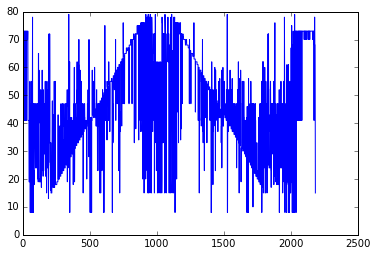

In [164]:
'''processing notes in a file using RNNPianoNoteProcessor()'''

proc = mad.features.notes.RNNPianoNoteProcessor()

act = proc('data/maps/AkPnBcht/ISOL/CH/MAPS_ISOL_CH0.1_F_AkPnBcht.wav')

preds = []
for i in range(len(act)):
    preds.append(act[i].argmax())

plt.plot(preds)
# NOTE: processed at 100fps. so, to extract actual note for output you'd need to:
# 1. go to onset (delta and/or sequential notes), 2. translate midi to note. that's handled below. 

114.0
25.0
0.0
62.0
176.0
0.820143884892
0.647727272727
0.72380952381
0.567164179104


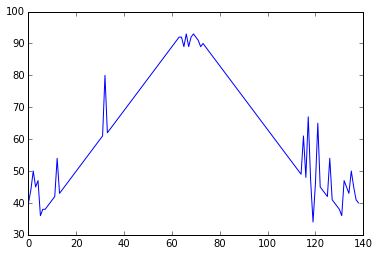

In [172]:
'''
for a full 176 (i.e., 2*88) incrementing then decrementing piano scale, PT achieves 63% tpr (82% precision,
65% recall, 72% f1, 57% accuracy). for pitches between 36 and 93: tpr 96%'''

tmp = ! PianoTranscriptor single 'data/maps/AkPnBcht/ISOL/CH/MAPS_ISOL_CH0.1_F_AkPnBcht.wav'
detections = mad.features.notes.load_notes(tmp)
annotations = mad.utils.midi.process_notes('data/maps/AkPnBcht/ISOL/CH/MAPS_ISOL_CH0.1_F_AkPnBcht.mid')

# p129: Evaluation class for measuring Precision, Recall and F-measure of notes.
eval_obj = mad.evaluation.notes.NoteEvaluation(detections, annotations, window=0.025, delay=0)

# p130 Class for averaging note evaluations.
eval_mean = mad.evaluation.notes.NoteMeanEvaluation(eval_obj, name=None)

plt.plot(detections[:,1])

print(eval_mean.num_tp)
print(eval_mean.num_fp)
print(eval_mean.num_tn)
print(eval_mean.num_fn)
print(eval_mean.num_annotations)
print(eval_mean.precision)
print(eval_mean.recall)
print(eval_mean.fmeasure)
print(eval_mean.accuracy)

In [154]:
# using external evalute.py

mad.features.notes.write_notes(detections, 'data/detections/tst1.notes', fmt=None)
mad.features.notes.write_notes(annotations[:,0:2], 'data/annotations/tst1.notes', fmt=None)

print("*** notes ***")
! evaluate notes -q -a '.notes' --ann_dir 'data/annotations' -d '.notes' --det_dir 'data/detections' 'tst1'
print

print("*** beats ***")
! evaluate beats -q -a '.notes' --ann_dir 'data/annotations' -d '.notes' --det_dir 'data/detections' 'tst1'
print

#print("*** tempo ***") SEEMS TO REQUIRE STRENGTH
#! evaluate tempo -q -a '.notes' --ann_dir 'data/annotations' -d '.notes' --det_dir 'data/detections' 'tst1'
#print

print("*** alignment ***")
! evaluate alignment -q -a '.notes' --ann_dir 'data/annotations' -d '.notes' --det_dir 'data/detections' 'tst1'

*** notes ***
sum for 1 files
  Notes:   176 TP:   114 FP:   25 FN:   62 Precision: 0.820 Recall: 0.648 F-measure: 0.724 Acc: 0.567 mean:  -0.6 ms std:   1.8 ms
mean for 1 files
  Notes: 176.00 TP: 114.00 FP: 25.00 FN: 62.00 Precision: 0.820 Recall: 0.648 F-measure: 0.724 Acc: 0.567 mean:  -0.6 ms std:   1.8 ms

*** beats ***
mean for 1 files
  F-measure: 0.800 P-score: 0.790 Cemgil: 0.881 Goto: 0.000 CMLc: 0.233 CMLt: 0.653 AMLc: 0.233 AMLt: 0.653 D: 2.477 Dg: 2.477

*** tempo ***
evaluating file 1 of 1Traceback (most recent call last):
  File "/Users/mdowns/.virtualenvs/audio_2.7_env/bin/evaluate", line 132, in <module>
    main()
  File "/Users/mdowns/.virtualenvs/audio_2.7_env/bin/evaluate", line 109, in main
    **vars(args))
  File "/Users/mdowns/.virtualenvs/audio_2.7_env/lib/python2.7/site-packages/madmom/evaluation/tempo.py", line 236, in __init__
    detections = load_tempo(detections, sort=sort, max_len=max_len)
  File "/Users/mdowns/.virtualenvs/audio_2.7_env/lib/python2.7/

### b. Chords

In [ ]:
# 2. chords
# problem: 0-3-7 and 0-4-7 target chords are rare in UCHO and RAND datasets. so, you either narrow file range
# or just use music files. would be nice to know chords-only model accuracy. 

    # a. return UCHO and RAND file names
        # RUN ONCE: function identifies valid chord files and mixes them among invalid UCHO files
# fnames = shake_n_bake_chords()

        # RUN AFTER: load resulting file
fnames = [fnames.rstrip('\n') for fnames in open('data/chords/wip/valAndInval.txt', 'U')]

# b. divide into train (80%) and test (20%), two folds each (divide validation subsequently) 
seq, folds = assign_file_to_folds(fnames)

# c. format x & y
for i in range(len(seq)): format_xy("chord", seq[i], i, folds[i])


In [581]:
# run batch processes on select music files

#fList = glob.glob('data/chords/wip/AkPnBcht/MUS/*.wav')

#for fname in listOfFiles:
! DCChordRecognition batch -o 'data/chords/wip' -s .mad.crf.txt 'data/maps/AkPnBcht/MUS/MAPS_MUS-alb_se3_AkPnBcht.wav'

#! CNNChordRecognition batch -s '.mad.dnn' listOfFiles
#! PianoTranscriptor single  -s 'mad.rnn' 'data/maps/AkPnBcht/MUS/MAPS_MUS-alb_se3_AkPnBcht.wav'

In [ ]:
# generate note and chord y's

tstMus = ['data/AkPnBcht/MUS/MAPS_MUS-alb_se3_AkPnBcht.wav', 'data/AkPnBcht/MUSMAPS_MUS-bach_846_AkPnBcht.wav']

for i in range(len(tstMus)):
    

In [ ]:
# evalute note and chord results

In [394]:
'''for testing performance of madmom crf/cnn chord identification modules. 
grabs directory files. tests both algorithms against text on/offset file. '''

def process_wavs(inWavDir, outTxtDir, outWavDir=None):
    '''
    reads wav, writes note, cnn chord and dnn chord files to target dir
    if tgtWavDir provided, appends chord, note and wav files incrementing. saves wav to target dir. 
    '''
    inWavs = glob.glob(inWavDir + '*.wav')
        
    wavs = []; begTm = 0; noteCtr = 0; chordCtr = 0
    
    for i in range(len(inWavs)):
        print("processing input file #", i)
        
        # retrieve .wav file
        #w = wave.open(inWavs[i], 'rb')
        #wavDur = float(w.getparams()[3])/w.getparams()[2]
        #wavs.append([w.getparams(), w.readframes(w.getnframes())] )
        #w.close()
        
        # process X: chord and note recognition from wave
        dnm = os.path.dirname(inWavs[i])
        fnm, _ = os.path.splitext(os.path.basename(inWavs[i]))
        inNm = dnm + fnm + '.txt'
        outNm = outTxtDir + fNm
        
        cnn_chord_rec(inWav[i], savTo = outNm + '.chord.cnn.txt'  )
        dnn_chord_rec(inWav[i], savTo = outNm + '.chord.dnn.txt' )
        rnn_note_rec(inWav[i], savTo = outNm + '.note.rnn.txt' )
        
        # process Y: corresponding y values from text files
        N, C = txt_to_y(inTxts[i])
        
        if N is not None:
            #if outWavDir is not None:
            #    # process it as one of batch incrementing times
            #    for i in range(N.shape[0]):
            #        N.OnsetTime.iloc[i] = begTm + N.OnsetTime.iloc[i]
            #        N.OffsetTime.iloc[i] = begTm + N.OffsetTime.iloc[i]
            #        
            #    if noteCtr == 0:
            #        notes = N
            #        noteCtr = 1
            #    else: 
            #        notes = notes.append(N)
            #else:
            # save it off
            notes['Duration'] = notes.OffsetTime - notes.OnsetTime
            notes = notes[['OnsetTime', 'MidiPitch', 'Duration' ]]        
            mad.features.notes.write_notes(np.array(notes),
                                           outNm + '.note.y.txt',
                                           fmt=['%.3f', '%d', '%.3f'])
            
        if C is not None:
            #if outWavDir is not None:
                #for i in range(C.shape[0]):
                #    C.OnsetTime.iloc[i] = begTm + C.OnsetTime.iloc[i]
                #    C.OffsetTime.iloc[i] = begTm + C.OffsetTime.iloc[i]
                #
                #if chordCtr == 0:
                #    chords = C
                #    chordCtr = 1
                #else: 
                #    chords = chords.append(C)
            #else:
            # save it off
            mad.features.chords.write_chords(np.array(chords), outNm + '.chord.y.txt')
        
        #if tgt_wav_dur is None:
        #    begTm = 0
        #    wav = []
        #else:
        #    begTm = begTm + wavDur
    
    # save files
    #if tgtWavDir is not None:
    #    # save wave file
    #    output = wave.open(tgtWavFile, 'wb')
    #    output.setparams(wavs[0][0])
    #    for i in range(len(wavs)):
    #        output.writeframes(wavs[i][1])
    #    output.close()
    #    svd.append(tgtWavFile)

process_wavs(inWavDir = 'data/maps/AkPnBcht/MUS',
             outTxtDir = 'data/wip/AkPnBcht/MUS', 
             outWavDir=None)


    #print(type(actNotes))
    #print(actNotes)
    #print(actChords)
#    pitches = []; chord = []       
#    onOffs = read_maps_note_file(line)
#    chord.append(onOffs.iloc[0,0])
#    chord.append(onOffs.iloc[0,1])
    
#    pitches = onOffs.MidiPitch.values.tolist()
    #onsets.append(onOffs.OnsetTime.values.tolist())
#    chord.append(m21.chord.Chord(pitches).pitchedCommonName)
    #chords.append(m21.chord.Chord(pitches).commonName)
    #chords.append(m21.chord.Chord(pitches).bass())
    #chords.append(m21.chord.Chord(pitches).root())
    #chords.append(m21.chord.Chord(pitches).quality)
    #chords.append(m21.chord.Chord(pitches).pitch)
#    chords.append(chord)


/Users/mdowns/.virtualenvs/audio_2.7_env/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
/Users/mdowns/.virtualenvs/audio_2.7_env/lib/python2.7/site-packages/ipykernel/__main__.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


saved:
['data/mix.wav', 'data/mix.notes.txt', 'data/mix.chords.txt']


In [618]:
'''achieves 45% major/minor triad recogniation. significantly slower than dnn model'''

def cnn_chord_rec(inWav, savTo=None):
    
    '''from Filip Korzeniowski and Gerhard Widmer, “A Fully Convolutional Deep Auditory Model for 
    Musical Chord Recognition”, Proceedings of IEEE International Workshop on Machine Learning for
    Signal Processing (MLSP), 2016..'''
    
    # instantiate madmom CNNChordFeatureProcessor
    featproc = mad.features.chords.CNNChordFeatureProcessor()
    
    # create DeepChromaChordRecognitionProcessor to decode chord sequence from extracted chromas
    decode = mad.features.chords.CRFChordRecognitionProcessor()
    
    # SequentialProcessor links dcp and decode steps to transcribe chord(s)
    chordrec = mad.processors.SequentialProcessor([featproc, decode])
    
    rtrn = chordrec(inWav)
    
    if savTo is not None: 
        mad.features.chords.write_chords(rtrn, savTo)
    else:
        return(pd.DataFrame(rtrn))

cnn_chord_rec('data/maps/AkPnBcht/MUS/MAPS_MUS-alb_se3_AkPnBcht.wav',
              'data/wip/AkPnBcht/MUS/MAPS_MUS-alb_se3_AkPnBcht.madChordCnn.txt')

In [619]:
'''achieves 35% major/minor triad recogniation'''

def dnn_chord_rec(inWav, savTo=None):
    
    '''from Filip Korzeniowski and Gerhard Widmer, “Feature Learning for Chord Recognition: The Deep
    Chroma Extractor”, Proceedings of the 17th International Society for Music Information Retrieval
    Conference (ISMIR), 2016.'''
    
    # instantiate madmom deep chroma processor to extract chroma vectors
    dcp = mad.audio.chroma.DeepChromaProcessor()
    
    # create DeepChromaChordRecognitionProcessor to decode chord sequence from extracted chromas
    decode = mad.features.chords.DeepChromaChordRecognitionProcessor()
    
    # SequentialProcessor links dcp and decode steps to transcribe chord(s)
    chordrec = mad.processors.SequentialProcessor([dcp, decode])
    
    rtrn = chordrec(inWav)
    
    if savTo is not None: 
        mad.features.chords.write_chords(rtrn, savTo)
    else:
        return(pd.DataFrame(rtrn))

#dcc_rslts = dcc_chord_rec('data/maps/AkPnBcht/MUS/MAPS_MUS-alb_se3_AkPnBcht.wav')

#dcc_rslts = dcc_chord_rec('data/maps/AkPnBcht/MUS/MAPS_MUS-alb_se3_AkPnBcht.wav',
#                          'data/wip/AkPnBcht/MUS/MAPS_MUS-alb_se3_AkPnBcht.madChordDcc.txt')

In [652]:
import argparse

def rnn_note_rec(mode,infile):
    """PianoTranscriptor"""

    # define parser
    p = argparse.ArgumentParser(
        formatter_class=argparse.RawDescriptionHelpFormatter, description='''
    The PianoTranscriptor program detects all notes (onsets) in an audio file
    according to the algorithm described in:
    "Polyphonic Piano Note Transcription with Recurrent Neural Networks"
    Sebastian Böck and Markus Schedl.
    Proceedings of the 37th International Conference on Acoustics, Speech and
    Signal Processing (ICASSP), 2012.
    Instead of 'LSTM' units, the current version uses 'tanh' units.
    This program can be run in 'single' file mode to process a single audio
    file and write the detected notes to STDOUT or the given output file.
    $ PianoTranscriptor single INFILE [-o OUTFILE]
    If multiple audio files should be processed, the program can also be run
    in 'batch' mode to save the detected notes to files with the given suffix.
    $ PianoTranscriptor batch [-o OUTPUT_DIR] [-s OUTPUT_SUFFIX] LIST OF FILES
    If no output directory is given, the program writes the files with the
    detected notes to same location as the audio files.
    The 'pickle' mode can be used to store the used parameters to be able to
    exactly reproduce experiments.
    ''')
    # version
    p.add_argument('--version', action='version',
                   version='PianoTranscriptor.2013')
    # input/output arguments
    mad.processors.io_arguments(p, output_suffix='.notes.txt')
    mad.features.ActivationsProcessor.add_arguments(p)
    
    # signal processing arguments
    mad.audio.signal.SignalProcessor.add_arguments(p, norm=False, gain=0, start=True, stop=True)
    
    # peak picking arguments
    mad.features.onsets.PeakPickingProcessor.add_arguments(p, threshold=0.35, 
                                                           smooth=0.09, combine=0.05)
    # midi arguments
    # import madmom.utils.midi as midi
    # midi.MIDIFile.add_arguments(p, length=0.6, velocity=100)
    p.add_argument('--midi', dest='output_format', action='store_const',
                   const='midi', help='save as MIDI')
    # mirex stuff
    p.add_argument('--mirex', dest='output_format', action='store_const',
                   const='mirex', help='use the MIREX output format')

    # parse arguments
    args = p.parse_args()

    # set immutable defaults
    args.fps = 100
    args.pre_max = 1. / args.fps
    args.post_max = 1. / args.fps

    # set the suffix for midi files
    if args.output_format == 'midi':
        args.output_suffix = '.mid'

    # print arguments
    if args.verbose:
        print(args)

    # input processor
    if args.load:
        # load the activations from file
        in_processor = mad.features.ActivationsProcessor(mode='r', **vars(args))
    else:
        # use a RNN to predict the notes
        in_processor = mad.features.notes.RNNPianoNoteProcessor()

    # output processor
    if args.save:
        # save the RNN note activations to file
        out_processor = mad.features.ActivationsProcessor(mode='w', **vars(args))
    else:
        # perform peak picking on the activation function
        mad.features.onsets.peak_picking = PeakPickingProcessor(**vars(args))
        # output everything in the right format
        if args.output_format is None:
            output = mad.features.notes.write_notes
        elif args.output_format == 'midi':
            output = mad.features.notes.write_midi
        elif args.output_format == 'mirex':
            output = mad.features.notes.write_mirex_format
        else:
            raise ValueError('unknown output format: %s' % args.output_format)
        out_processor = [peak_picking, output]

    # create an IOProcessor
    processor = mad.processors.IOProcessor(in_processor, out_processor)

    # and call the processing function
    args.func(processor, **vars(args))

rnn_note_rec('single', 'data/maps/AkPnBcht/MUS/MAPS_MUS-alb_se3_AkPnBcht.wav')

usage: __main__.py [-h] [--version] [-v] [--save] [--load] [--sep SEP]
                   [--start START] [--stop STOP] [--norm] [--gain GAIN]
                   [-t THRESHOLD] [--smooth SMOOTH] [--combine COMBINE]
                   [--delay DELAY] [--midi] [--mirex]
                   {pickle,single,batch} ...
__main__.py: error: invalid choice: '/Users/mdowns/Library/Jupyter/runtime/kernel-656719a0-d7f3-4386-a2c5-ae0de509d831.json' (choose from 'pickle', 'single', 'batch')


SystemExit: 2

TypeError: 'level' is an invalid keyword argument for this function

In [679]:
import PianoTranscriptor

mylist=('data/maps/AkPnBcht/MUS/MAPS_MUS-alb_se3_AkPnBcht.wav' 'data/maps/AkPnBcht/MUS/MAPS_MUS-bach_846_AkPnBcht.wav')
PianoTranscriptor('batch', mylist)

TypeError: 'module' object is not callable

In [631]:


    Use:

$ mdcNo=('0021' '0022' '0036' '0055' '0057' '0059' '0061' '0062' '0063' '0065' '0066' '0086' '0095' '0098' '0106' '0110' '0113' '0114' '0115' '0121' '0126' '0128' '0135' '0141' '0143' '0153' '0155' '0158')
$ python argp.py "${mdcNo[@]}"


def rnn_note_rec(mode, infile):
    
    # signal processing arguments
    mad.audio.signal.SignalProcessor.add_arguments(norm=False, gain=0, start=True, stop=True)
    
    # peak picking arguments
    mad.features.onsets.PeakPickingProcessor.add_arguments(threshold=0.35, smooth=0.09, combine=0.05)
    
    # set immutable defaults
    args.fps = 100
    args.pre_max = 1. / args.fps
    args.post_max = 1. / args.fps
    
    # use a RNN to predict the notes
    in_processor = mad.features.notes.RNNPianoNoteProcessor()
    
    # perform peak picking on the activation function
    peak_picking = mad.features.onsets.PeakPickingProcessor(infile) # **vars(args)? 
    
    # set output
    output = mad.features.notes.write_notes
    out_processor = [peak_picking, output]
    
    # create an IOProcessor
    processor = mad.processors.IOProcessor(in_processor, out_processor)
    
    # and call the processing function
    args.func(processor, infile)


rslt = rnn_note_rec("single", 'data/maps/AkPnBcht/MUS/MAPS_MUS-alb_se3_AkPnBcht.wav')

TypeError: add_arguments() takes at least 1 argument (4 given)

In [657]:
! PianoTranscriptor single 'data/maps/AkPnBcht/MUS/MAPS_MUS-alb_se3_AkPnBcht.wav'

usage: PianoTranscriptor [-h] [--version] [-v] [--save] [--load] [--sep SEP]
                         [--start START] [--stop STOP] [--norm] [--gain GAIN]
                         [-t THRESHOLD] [--smooth SMOOTH] [--combine COMBINE]
                         [--delay DELAY] [--midi] [--mirex]
                         {pickle,single,batch} ...
PianoTranscriptor: error: invalid choice: 'data/maps/AkPnBcht/MUS/MAPS_MUS-alb_se3_AkPnBcht.wav' (choose from 'pickle', 'single', 'batch')


In [647]:
#! export mylist=('data/maps/AkPnBcht/MUS/MAPS_MUS-alb_se3_AkPnBcht.wav', 'data/maps/AkPnBcht/MUS/MAPS_MUS-bach_846_AkPnBcht.wav')
! PianoTranscriptor -v single 'data/maps/AkPnBcht/MUS/MAPS_MUS-alb_se3_AkPnBcht.wav'

#! PianoTranscriptor -h

Namespace(combine=0.05, delay=0.0, fps=100, func=<function process_single at 0x10c7e5b90>, gain=0, infile=<open file 'data/maps/AkPnBcht/MUS/MAPS_MUS-alb_se3_AkPnBcht.wav', mode 'rb' at 0x10d3d2d20>, load=False, norm=False, num_threads=4, outfile=<open file '<stdout>', mode 'w' at 0x10b8d8150>, output_format=None, post_max=0.01, pre_max=0.01, save=False, sep=None, smooth=0.09, start=None, stop=None, threshold=0.35, verbose=1)
0.510	43
0.510	55
0.510	62
0.510	67
0.510	71
0.780	62
0.780	67
0.780	71
0.910	66
1.040	65
1.040	71
1.310	64
1.440	63
1.580	45
1.580	57
1.580	62
1.580	66
1.580	72
1.840	38
1.850	50
1.850	66
1.850	72
1.980	62
2.120	43
2.120	55
2.120	62
2.120	67
2.120	71
2.390	67
2.390	71
2.520	66
2.660	65
2.660	71
2.930	50
2.930	64
3.060	63
3.200	45
3.200	57
3.200	62
3.200	66
3.200	72
3.470	38
3.470	50
3.470	66
3.470	72
3.620	62
3.760	43
3.760	67
3.760	71
3.760	79
3.770	55
3.770	74
4.040	50
4.180	52
4.180	64
4.310	50
4.590	50
4.870	57
4.870	62
4.870	66
4.870	72
4.870	78
5.140	50
5.2

In [459]:
'''chord rec using external DCChordRecognition'''
# $ DCChordRecogniser single INFILE [-o OUTFILE]
dcc_chord_detect = ! DCChordRecognition single 'data/mix.wav'
dcc_chord_detect = mad.features.chords.load_chords(crf_chord_detect)
print(pd.DataFrame(dcc_chord_detect))
# can't figure out how to pass LIST OF FILES
# $ DCChordRecogniser batch [-o OUTPUT_DIR] [-s OUTPUT_SUFFIX] LIST OF FILES

'''chord rec using external CNNChordRecognition'''
cnn_chord_detect = ! CNNChordRecognition single 'data/mix.wav'
cnn_chord_detect = mad.features.chords.load_chords(cnn_chord_detect)
print(pd.DataFrame(cnn_chord_detect))

'''note detection using external PianoTranscriptor'''
rnn_note_detect = ! PianoTranscriptor single 'data/mix.wav'
rnn_note_detect = mad.features.notes.load_notes(rnn_note_detect)
pd.DataFrame(rnn_note_detect)

#tmp = rnn_note_detect
#new_col = []
#for i in range(tmp.shape[0]):
#    a = m21.note.Note(int(tmp[i,1]))
#    new_col.append(a.nameWithOctave)
#new_col = np.asarray(new_col)
#new_col = new_col.reshape(tmp.shape[0], 1)
#tmp = np.append(tmp, new_col, 1)


[]


/usr/local/Cellar/python/2.7.11/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/lib/npyio.py:893: UserWarning: loadtxt: Empty input file: "[]"
  warnings.warn('loadtxt: Empty input file: "%s"' % fname)


34.0
4.0
0.0
26.0
60.0
0.894736842105
0.566666666667
0.69387755102
0.53125


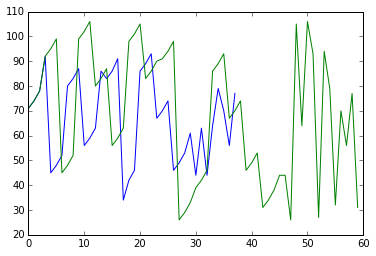

In [399]:
# Evaluate notes
#annotations = mad.utils.midi.process_notes('data/maps/AkPnBcht/ISOL/CH/MAPS_ISOL_CH0.1_F_AkPnBcht.mid')
annotations = mad.features.notes.load_notes('data/mix.notes.txt')

# p129: Evaluation class for measuring Precision, Recall and F-measure of notes.
eval_obj = mad.evaluation.notes.NoteEvaluation(rnn_note_detect, annotations, window=0.025, delay=0)

# p130 Class for averaging note evaluations.
eval_mean = mad.evaluation.notes.NoteMeanEvaluation(eval_obj, name=None)

plt.plot(rnn_note_detect[:,1])
plt.plot(annotations[:,1])

print(eval_mean.num_tp)
print(eval_mean.num_fp)
print(eval_mean.num_tn)
print(eval_mean.num_fn)
print(eval_mean.num_annotations)
print(eval_mean.precision)
print(eval_mean.recall)
print(eval_mean.fmeasure)
print(eval_mean.accuracy)

# Evaluate chords
#annotations = mad.utils.midi.process_notes('data/maps/AkPnBcht/ISOL/CH/MAPS_ISOL_CH0.1_F_AkPnBcht.mid')
annotations = mad.features.chords.load_chords('data/mix.chords.txt')

# new valuation class for measuring Precision, Recall and F-measure of notes.
eval_obj = ! evalute_chords.ChordEvaluation(crf_chord_detect, annotations, window=0.025, delay=0)

# new class for averaging note evaluations.
eval_mean = ! evalute_chords.ChordMeanEvaluation(eval_obj, name=None)

print(eval_mean.num_tp)
print(eval_mean.num_fp)
print(eval_mean.num_tn)
print(eval_mean.num_fn)
print(eval_mean.num_annotations)
print(eval_mean.precision)
print(eval_mean.recall)
print(eval_mean.fmeasure)
print(eval_mean.accuracy)

In [541]:
# put in "format" or "transform" function

# txt_to_y format: [OnsetTime, OffsetTime, Midipitch]

def flip_formats(inFile, frmFrmt, toFrmt):
    
    # valid to/froms: madNote, mapNote, madChord, m21Chord
    
    inHt, inWd = inFile.shape
    
    # data types
    MAD_NOTE_HEADER_1 = ['note_time', 'MIDI_note']
    MAD_NOTE_HEADER_2 = ['note_time', 'MIDI_note', 'duration']
    MAD_NOTE_HEADER_3 = ['note_time', 'MIDI_note', 'duration', 'MIDI_note']
        
    MAD_NOTE_DTYPE_1 = [('note_time', np.float), ('MIDI_note', np.int)]
    MAD_NOTE_DTYPE_2 = [('note_time', np.float), ('MIDI_note', np.int), ('duration', np.float)]
    MAD_NOTE_DTYPE_3 = [('note_time', np.float), ('MIDI_note', np.int), ('duration', np.float), ('MIDI_note', np.int)]
    
    MAD_CHORD_DTYPE = [('start', np.float), ('end', np.float), ('label', 'U32')]

    MAP_NOTE_HEADER = ['OnsetTime', 'OffsetTime', 'MidiPitch']
    MAP_CHORD_HEADER = ['OnsetTime', 'OffsetTime', 'ChordLabel']
    
    #M21_NOTE_DTYPE = 'f4,f4,int'
    #M21_CHORD_DTYPE = 'f4,f4,S10'
    
    if frmFrmt == "madNote":
        
        if toFrmt == "mapNote" or toFrmt == "m21Chord" or toFrmt == "madChord":
            
            notes = np.zeros(shape=(inHt, 3), dtype=float) # dtype defaults to float64
            notes[:,0] = inFile[:,0]
            notes[:,2] = inFile[:,1].astype(int)
            
            # if no duration
            if inFile.shape[1] == 2:
                notes[:,1] = 0
                
            # if duration
            else:
                notes[:,1] = inFile[:,0] + inFile[:,2]
                
            if toFrmt == "mapNote":
                return(notes)
        
            elif toFrmt == "m21Chord" or toFrmt == "madChord":
                
                notes = pd.DataFrame(notes, columns=['OnsetTime', 'OffsetTime', 'MidiPitch'])
                notes = tmp.round({'OnsetTime': 2, 'OffsetTime': 2, 'MidiPitch': 0})
                notes = tmp.sort_values(['OnsetTime', 'MidiPitch'],
                                      axis=0, ascending=True, inplace=False,
                                      kind='quicksort', na_position='last')
                
                notes["MidiPitch"] = tmp['MidiPitch'].astype(int)
                
                notes, chords = txt_to_y(tmp, mode="thisFile")
                
                if toFrmt == "m21Chord":
                    return(chords)
            
                elif toFrmt == "madChord":
                    # NOTE: UNTIL YOU FIND OUT HOW THEY'RE CLASSING THEIR CHORDS, DON'T SPEND TIME HERE.
                    lines = [line.rstrip('\n').split('\t') for line in open('data/mad2m21map.txt', 'U')]
                    headers = lines[0]; lines = lines[1:len(lines)]
                    lines = pd.DataFrame(lines, columns= headers)
                    
                    d = dict(zip(lines.m21_chord_pitchedCommonName, lines.mad_chord))
                    
                    for i in range(chords.shape[0]):
                        try:
                            chords.ChordLabel.iloc[i] = d[chords.ChordLabel.iloc[i]]
                        except:
                            chords.ChordLabel.iloc[i] = 'N'
                            
                    return(chords)
        # NOTE: DON'T SPEND TIME GOING FROM MAD.CHORD LABELS TO M21. JUST USE MODEL OUTPUTS TO PREDICT. 
                
                

#print(flip_formats(rnn_note_detect, "madNote", "mapNote"))
print(flip_formats(rnn_note_detect, "madNote", "m21Chord"))
print(flip_formats(rnn_note_detect, "madNote", "madChord"))


/Users/mdowns/.virtualenvs/audio_2.7_env/lib/python2.7/site-packages/ipykernel/__main__.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


    OnsetTime  RootMidiPitch            ChordLabel
0        0.51           71.0   B4-interval class 3
4        8.11           45.0        A2-minor triad
7       15.91           80.0       E-6-minor triad
10      19.81           56.0       E-4-minor triad
14      27.41           83.0   B5-interval class 3
17      38.51           34.0  B-1-interval class 4
20      42.41           86.0        D6-minor triad
23      46.10           67.0        G4-minor triad
26      49.61           46.0       B-2-minor triad
30      56.60           44.0  E-4-interval class 5
    OnsetTime  RootMidiPitch ChordLabel
0        0.51           71.0          N
4        8.11           45.0      A:min
7       15.91           80.0          N
10      19.81           56.0          N
14      27.41           83.0          N
17      38.51           34.0          N
20      42.41           86.0      D:min
23      46.10           67.0      G:min
26      49.61           46.0          N
30      56.60           44.0          N

In [ ]:
# p91

# Load labelled chord segments from a file. One chord label per line with: 
# <start_time> <end_time> <chord_label>. All times should be given in seconds.
madmom.features.chords.load_chords(filename)

# Write chord segments to a file.
madmom.features.chords.write_chords(chords, filename)

'''use below when you "roll-your-own nn. it goes from frame-based class ests to cord defs'''
# Converts nn-generated major/minor chord class preds to human-readable chord labels. 
# class preds are assumed to be spaced equidistant in time as defined by the fps parameter i.e., one class pred per frame
# classes used by their nn assign 0-11 for major chords starting with root ‘A’, and for 12-23 minor chords.
# class 24 represents ‘N’, the no-chord class.
madmom.features.chords.majmin_targets_to_chord_labels(targets, fps)

'''
1. can their algos differentiate btwn notes and chords? or do you end up w/ a bunch of false positives?
run a test file w/ 20 note and 20 chord shounds through RNNPiano, CNNChord and CNFChord.

A: overlap. note uncovers many notes in chords. chords predict (incorrectly) on notes. so, question is how
can we vector on correct chord (in particular) estimates using CNN, CRF and RNN.

'''

### c. Music

In [ ]:
# folds used in article: url = 'http://www.eecs.qmul.ac.uk/~sss31/TASLP/'

fnames = ['train1.txt','test1.txt','train2.txt','test2.txt','train3.txt','test3.txt','train4.txt','test4.txt']
seq = ['train','test','train','test','train','test','train','test',]

# for each train and test set across four folds...
for i in range(len(fnames)):
    
    #... retrieve file names
    fold = [f.rstrip('\n') for f in open('data/music/wip/' + fnames[i], 'U')]
    
    # pass them to formatter
    format_xy("music", seq[i], i, fold)
    

### d. Common Functions

In [ ]:
def assign_files_to_folds(fnames):
    
    num_files = len(fnames); print("total files:",num_files)
    
    rand.seed(123)
    rand.shuffle(fnames)
    size = int(num_files / 10)

    trn1 = fnames[0:(4*size)]
    trn2 = fnames[(4*size):(8*size)]
    tst1 = fnames[(8*size):(9*size)]
    tst2 = fnames[(9*size):(10*size)]
    
    seq = ['train', 'train', 'test', 'test']
    fls = [trn1, trn2, tst1, tst2]
    
    return(seq, fls)

In [ ]:
def format_xy(soundType, trnTst, foldNum, fold):
    
    dname = ''.join('/data', sountType, '/fold', str(foldNum))
    max_rows = 150000
    batch_ctr = 1
    new_stack = 1
    
    # generate x's and y's for each file in fold, append and save in batches
    for line in range(fold.shape[0]):
        x_note, wav_dur, wav_frames = wav_pitch_to_x(line)
        x_chord, wav_dur, wav_frames = wav_chord_to_x_1(line)
        y_pitch, y_chord = txt_to_y(line, wav_dur, wav_frames)
        
        if new_stack == 1 or xStack.shape[0] < max_rows:
            if new_stack == 1:
                xStack = x
                yPitchStack = y_pitch
                yChordStack = y_chord
                
                new_stack = 0
            
            else: 
                xStack.append(x)
                yPitchStack.append(y_pitch)
                yChordStack.append(y_chord)
                
        else:
            # normalize X values
            if soundType == "note":
                xStack = (xStack - note_mean) / note_sd
            elif soundType == "chord":
                xStack = (xStack - chord_mean) / chord_sd
            elif soundType == "music":
                xStack = (xStack - music_mean) / music_sd
            
            # save off batch
            fname = ''.join(dname,'/batch',str(batch_ctr),trnTst,'x.txt')
            with open(fname, 'wb') as f:
                pickle.dump(xStack, f)
            print("pickled:" fname)
            
            fname = ''.join(dname,'/batch',str(batch_ctr),trnTst,'y_pitch.txt')
            with open(fname, 'wb') as f:
                pickle.dump(yPitchStack, f)
            print("pickled:" fname)
            
            fname = ''.join(dname,'/batch',str(batch_ctr),trnTst,'y_chord.txt')
            with open(fname, 'wb') as f:
                pickle.dump(yChordStack, f)
            print("pickled:" fname)
            
            batch_ctr = batch_ctr + 1
            new_stack == 1    


In [6]:
from scipy.ndimage.filters import maximum_filter

def wav_pitch_to_x(wav_file):
    
    # load wav file
    sig = mad.audio.signal.Signal(wav_file, sample_rate = NUM_SAMPLES, num_channels = 1, )
    wav_dur = sig.shape[0] / sig.sample_rate
    
    # Use FramedSignal object to split the signal into frames w/ 2048 samples ea w/ 441 sample overlap 
    fs = mad.audio.signal.FramedSignal(sig, frame_size = NUM_FRAMES, hop_size = NUM_HOPS) # 2048 / 441
    
    # Using FramedSignal, calculate short term fourrier transform
    stft = mad.audio.stft.STFT(fs[0])
    
    # spec = mad.audio.spectrogram.Spectrogram(stft); print(spec.shape)
    spec = mad.audio.spectrogram.Spectrogram(sig, num_channels=1, frame_size = NUM_FRAMES, hop_size = NUM_HOPS)
    
    # what value can the second channel provide? CNN can handle multiple channels. so, may want a version
    # of this which uses 2+ channels and, if necessary, doesn't run through problemantic down stream process. 
    
    # spectral_flx creates linearly spaced magnitude spectogram filtered logarithmically (24 bands / octive)
    sf = mad.features.onsets.spectral_flux(spec)
    
    # filtering
    filt_spec = mad.audio.spectrogram.FilteredSpectrogram(spec,
                                                          filterbank = mad.audio.filters.LogFilterbank,
                                                          num_bands = NUM_BANDS)
    
    # To better match the perception of loudness of humans, the filtered spectrogram is also scaled logarithmically
    log_spec = mad.audio.spectrogram.LogarithmicSpectrogram(filt_spec, add=1)
    
    # maximum filter size spreads over 3 frequency bins
    size = (1, 3)
    max_spec = maximum_filter(log_spec, size=size)

    # Now we continue to calculate the difference w.r.t. this "widened" spectrogram.
    diff = np.zeros_like(log_spec)
    diff[1:] = (log_spec[1:] - max_spec[: -1])
    pos_diff = np.maximum(0, diff)
    
    # sum everything to get the onset detection function
    superflux = np.sum(pos_diff, axis=1)
    
    # comparison using single function call
    #log_filt_spec = mad.audio.spectrogram.LogarithmicFilteredSpectrogram(wav_file,
    #                                                                     sample_rate = samples,
    #                                                                     num_channels = 1,
    #                                                                     num_bands = bands,
    #                                                                     frame_size = frames,
    #                                                                     hop_size = hops)
    
    #superflux1 = mad.features.onsets.superflux(log_filt_spec); print(superflux.shape)
    
    return(superflux, wav_dur, superflux.shape[0])
    #return(log_spec, max_spec, superflux, wav_dur, superflux.shape[0])

#log_spec1, max_spec1, superflux1, wav_dur1, wav_frames1 = wav_pitch_to_x('data/maps/AkPnCGdD/MUS/MAPS_MUS-chp_op18_AkPnCGdD.wav')
#print("wave duration:", wav_dur1)
#print("wave frames:", wav_frames1)
#plt.figure()
#plt.imshow(log_spec1.T, origin='lower', aspect='auto')
#plt.figure()
#plt.imshow(max_spec1.T, origin='lower', aspect='auto')
#plt.figure()
#plt.plot(superflux1)

In [ ]:
'''for manual chord recognition development i.e., using neural net. best to start w/ madmon as 
opposed to essentia below as madmom you can get their alogs online'''

from scipy.ndimage.filters import maximum_filter
from essentia.standard import *

def wav_to_chord_x_3(wav_file):
    
    # instantiate the audio loader:
    loader = essentia.standard.MonoLoader(filename = wav_file)

    # and then we actually perform the loading:
    audio = loader()

    # instantiate windowing 
    w = Windowing(type = 'blackmanharris74')
    spectrum = Spectrum()
    mfcc = MFCC()
    speaks = SpectralPeaks(sampleRate = NUM_SAMPLES)
    hpcp = HPCP(sampleRate = NUM_SAMPLES)

    # process frames
    mfccs = []; spec_f = []; spec_m = []; chroma = []
    for frame in FrameGenerator(audio, frameSize = NUM_FRAMES, hopSize = NUM_HOPS):
        # calculate Mel-frequency cepstrum coefficients
        mfcc_bands, mfcc_coeffs = mfcc(spectrum(w(frame))) 
        mfccs.append(mfcc_coeffs)
        
        # calculate spectral peak frequencies, magnitudes
        sp_f, sp_m = speaks(spectrum(w(frame)))
        spec_f.append(sp_f); spec_m.append(sp_m)
        
        chroma.append(hpcp(sp_f, sp_m))
    
    mfccs = essentia.array(mfccs).T
    print(mfccs.shape)
    #plt.figure(); plt.plot(mfccs[1,:], aspect = 'auto')
    
    #spec_f is a list of lists
    print(len(spec_f))
    
    #spec_m is a list of lists
    print(len(spec_m))
    
    chroma = essentia.array(chroma).T
    print(chroma.shape)
    #plt.figure(); plt.plot(chroma[1:], aspect = 'auto')
    
    return(mfccs chroma, wav_dur, chorma.shape[1])

mfccs, chroma, wav_dur, wav_frames = wav_to_x('data/maps/AkPnCGdD/MUS/MAPS_MUS-chp_op18_AkPnCGdD.wav')

In [ ]:
#chords = [[25, 29, 32], [47, 51, 54], [63, 67, 70], [101, 105, 108], [23, 27, 30], [87, 91, 94], [75, 79, 82]]

chords = [[50,53,57],[62,66,69]]

for i in chords:
    print(m21.chord.Chord(i).pitchedCommonName)
    
for i in chords[0]:
    print(m21.note.Note(i).octave)

chords = np.array([[0.50000432, 60],
                  [0.50000432, 63],
                  [0.50000432, 67],
                  [1.10000432, 60],
                  [1.10000432, 64],
                  [1.10000432, 67]])
    
mad.features.notes.write_notes(chords, 'data/sounds1')


In [ ]:
# p 173 IO: Input/Output Processor which processes the input data with the input processor and pipes everything
# into the given output processor. All Processors defined in the input chain are sequentially called with the 
# ‘data’ argument only. The output Processor is the only one ever called with two arguments (‘data’, ‘output’).
class madmom.processors.IOProcessor(in_processor, out_processor=None)

# p174 batch: Process a list of files with the given Processor in batch mode.
madmom.processors.process_batch(processor, files, output_dir=None, output_suffix=None,
strip_ext=True, num_workers=4, shuffle=False, **kwargs)

In [ ]:
mad.features.notes.write_notes(tmp, 'data/sounds1')

In [540]:
def txt_to_y(inFile, out_fmt='runTime', wav_dur=0, wav_frames=0, mode="savedFile"):
    # valid y_modes: "pitch_only", "chord_only", "music"
    
    # translates text files w/ onset, offset and pitch into two Y matricies:
    #  1. y_notes: [n, 89] vect of binaries representing:
    #     a. notes C3 on piano keyboard A1->C#9 (midi 21-109)
    #     b. "not target class" including notes/pitches outside range AND in-range chords formed by 2+ keys
    #  2. y_chords: [n, 120] vect of the "major" and "minor" triads (some of the most common chords in western music):
    #     a. 12 pitch classes i.e., C, C#, D, D#, E, F, F#, G, G#, A, A#, B
    #     b. 5 (of total 7.5) octaves i.e., C in 4th octave: C4
    #     c. 1 (of total 6 in db) key combinations i.e., triad (not 2, 4, 5, 6 or 7 key combinations)
    #     d. major (root pitch, +4 pitches, +3 pitches) or  minor (root pitch, +3, +4) quality 
    #        i.e., C major triad 4th octave: C4, E4, G4. C minor triad 4th octave: C4, D#4, G4
    #     e. NOT IMPLEMENTED: 2 inversions that are defined by the lowest note in the chord
    #        i.e., C4, E4, G4 becomes E4, G4, C5 in the first inversion  
    #     f. "not target class" including single notes and the multitude of less common 2+ note chords
    #     other options: http://www.daigleharp.com/Images/Help%20Files/commonchordsforautoharp.pdf, http://www.hooktheory.com/blog/i-analyzed-the-chords-of-1300-popular-songs-for-patterns-this-is-what-i-found/
    
    if mode == "savedFile":
        # reads text file into dataframe, sort and round
        lines = read_maps_note_file(inFile)
    else:
        lines = inFile
    
    chord_rcds_fl = 0; in_chord_fl = 0; pitch_rcds_fl = 0; rval = 0
    
    # if single line file, save pitch
    if lines.shape[0] == 1:
        active_pitches = lines.iloc[[0]]
        pitch_rcds_fl = 1
    
    # otherwise, step thru lines assigning notes to pitches or chords
    else:
        for i in range(1,lines.shape[0]):
            
            # process pitches: madmom RNN good at extracting notes even from chords. 
            # so, process all rcds as note records
            if pitch_rcds_fl == 0:
                # ...then instantiate note array using prior line
                active_pitches = lines.iloc[[i-1]]
                pitch_rcds_fl = 1
                    
            # ... and note array already started, then append line to note array
            else:
                active_pitches = active_pitches.append(lines.iloc[[i-1]])
                
            # if i is the last line in input array, move it to pitch array also
            if i == (lines.shape[0]-1):
                if pitch_rcds_fl == 0:
                    active_pitches = lines.iloc[[i]]
                else:
                    active_pitches = active_pitches.append(lines.iloc[[i]])
                        
            # process chords: if note record has same onset (w/in rounding tolerance of 0.01) as prior...
            if lines.iloc[i,0] == lines.iloc[i-1,0]: #and lines.iloc[i,1] == lines.iloc[i-1,1]:
                # ... and it's the first chord in piece,...
                if chord_rcds_fl == 0:
                    # ...then instantiate chord array using the prior pitch (line)
                    active_chords = lines.iloc[[i-1]]
                    chord_rcds_fl = 1; in_chord_fl = 1
                
                # otherwise, append the prior pitch (line) to chord array
                else:
                    active_chords = active_chords.append(lines.iloc[[i-1]])
                    in_chord_fl = 1
                
                # if last line in input array (and it's same as prior), move it to chord array
                if i == (lines.shape[0]-1):
                    active_chords = active_chords.append(lines.iloc[[i]])
                    
            # so, current line doesn't have same onset...
            else:
                #...but you were in a chord. so, you still want to append prior pitch (line) to the chord array.
                if in_chord_fl == 1:
                    active_chords = active_chords.append(lines.iloc[[i-1]])
                    in_chord_fl = 0
    
    if out_fmt == "runTime":
        if(pitch_rcds_fl == 0):
            active_pitches = None
            
        if(chord_rcds_fl == 0):
            active_chords = None
        
        else:
            uniq_onset = active_chords.drop_duplicates(subset="OnsetTime", keep='first')
            
            for i in range(uniq_onset.shape[0]):
                
                cur_pitches = active_chords.MidiPitch[active_chords.OnsetTime == uniq_onset.OnsetTime.iloc[i]]
                cur_chord = m21.chord.Chord(np.array(cur_pitches)).pitchedCommonName
                
                #if cur_chord in CHORD_CLASSES:
                uniq_onset.MidiPitch.iloc[i] = cur_chord
                #else:
                #    uniq_onset.MidiPitch.iloc[i] = NOT_TGT_LABEL
                    
            active_chords = uniq_onset
            active_chords.columns = ['OnsetTime', 'RootMidiPitch', 'ChordLabel']
            
        return(active_pitches, active_chords)
    
    elif out_fmt == "oneHot":
        
        # format time index w/ slices = wave frame sample rate        
        time_ctr = 0
        time_incr = float(wav_dur) / wav_frames
        time_idx = []
    
        for k in range(wav_frames): 
            time_idx.append(np.round(time_ctr,2))
            time_ctr = time_ctr + time_incr
    
        # initialize y matrices    
        Y_pitch = pd.DataFrame(np.zeros((len(time_idx), NUM_PITCH_CLASSES), dtype=int),
                               index = time_idx, columns = PITCH_CLASSES)
        Y_pitch.iloc[:,0] = 1 # set NOT_TGT_CLASS on as default
        
        Y_chord = pd.DataFrame(np.zeros((len(time_idx), NUM_CHORD_CLASSES), dtype=int),
                               index = time_idx, columns = CHORD_CLASSES)
        Y_chord.iloc[:,0] = 1 # set NOT_TGT_CLASS on as default
    
        time_idx = pd.DataFrame(time_idx)

        # step thru active, single pitch records
        if(pitch_rcds_fl > 0):
        
            for i in range(active_pitches.shape[0]):
               
                # ...find the ids of all time indexes that fall after the onset...
                more = time_idx[time_idx[0] >= active_pitches.iloc[i,0]].index.tolist()
        
                #...and the ids of all time indexes that fall before the offset
                less = time_idx[time_idx[0] < active_pitches.iloc[i,1]].index.tolist()
        
                # the intersection are the id's of time indexes where a pitch was active
                net = np.intersect1d(more, less, assume_unique=False)
        
                # flip the class variable for each time index
                for j in range(len(net)):
                    # if it's a valid pitch...
                    if active_pitches.iloc[i,2] in PITCH_CLASSES:
                        # ...flip the corresponding pitch column
                        Y_pitch.loc[time_idx.iloc[net[j],0], int(active_pitches.iloc[i,2])] = 1
                        Y_pitch.loc[time_idx.iloc[net[j],0], NOT_TGT_LABEL] = 0
            
        # step thru active chord records
        if(chord_rcds_fl > 0):
            uniq_onset = active_chords.OnsetTime.unique()
          
            for i in range(uniq_onset.shape[0]):
                cur_pitches = active_chords[active_chords.iloc[:,0] == uniq_onset[i]]
                cur_chord = m21.chord.Chord(np.array(cur_pitches.iloc[:,2])).pitchedCommonName
            
                # ...find the ids of all time indexes that fall after the onset...
                more = time_idx[time_idx[0] >= uniq_onset[i]].index.tolist()
                            
                #...and the ids of all time indexes that fall before the offset
                less = time_idx[time_idx[0] < cur_pitches.iloc[0,1]].index.tolist()
            
                # the intersection are the id's of time indexes where a pitch was active
                net = np.intersect1d(more, less, assume_unique=False)
        
                # if it's a valid chord,...
                if cur_chord in CHORD_CLASSES:
                    # ...cycle thru time indexes...
                    for j in range(len(net)):
                        # ...flipping the corresponding chord column
                        Y_chord.loc[time_idx.iloc[net[j],0], cur_chord] = 1
                        Y_chord.loc[time_idx.iloc[net[j],0], NOT_TGT_LABEL] = 0
                    
                    rval = 1
                
        #return([rval])
        return(Y_pitch, Y_chord)
        

# test single pitch
#ptch, crd = txt_to_y('data/maps/AkPnBcht/ISOL/NO/MAPS_ISOL_NO_F_S0_M23_AkPnBcht.txt', 2.6, 260)

# test multiple notes
#ptch, crd = txt_to_y('data/maps/AkPnCGdD/ISOL/TR1/MAPS_ISOL_TR1_F_S0_M29_AkPnCGdD.txt', 4.7, 470) # 47, 4700

# test single chord
    # not recognized
#ptch, crd = txt_to_y('data/maps/AkPnCGdD/UCHO/I60-68/C0-1-4-8/MAPS_UCHO_C0-1-4-8_I60-68_S0_n1_AkPnCGdD.txt', 1.5, 150)
    # recognized
#ptch, crd = txt_to_y('data/maps/AkPnCGdD/UCHO/I60-68/C0-3-7/MAPS_UCHO_C0-3-7_I60-68_S0_n1_AkPnCGdD.txt', 1.6, 160)
#print(m21.chord.Chord([67,70,74]).pitchedCommonName)
#crd.iloc[49:151,(0,40)]

# test multiple chords - next section

# test music
#ptch, crd = txt_to_y('data/maps/AkPnCGdD/MUS/MAPS_MUS-chp_op18_AkPnCGdD.txt', 31.1, 31141, "pitch")

In [314]:
def read_maps_note_file(txt_file):
    # reads text file into dataframe, sort and round
    
    lines = [line.rstrip('\n').split('\t') for line in open(txt_file, 'U')]
    
    headers = lines[0]; lines = lines[1:len(lines)]
    
    lines = pd.DataFrame(lines, columns=[headers[0], headers[1], 
                                         headers[2]]).convert_objects(convert_numeric=True)
    
    lines = lines.round({'OnsetTime': 2, 'OffsetTime': 2, 'MidiPitch': 0})
    
    lines = lines.sort_values(['OnsetTime', 'OffsetTime', 'MidiPitch'], 
                              axis=0, ascending=True, inplace=False, 
                              kind='quicksort', na_position='last')
    
    return(lines)

In [ ]:
def save_list(toSave, toDir, toName, toType):
    fullName = ''.join([toDir, toName, toType])
    with open(fullName, 'w') as f:
        for item in toSave:
            f.write(item + '\n')

def pickle_it(toPick, toDir, toName):
    with open(toDir + toName, 'wb') as f:
        pickle.dump(toPick, f)
        print("pickled:", toName)

def unpickle_it(frmDir, frmName):
    with open(frmDir + frmName, 'rb') as f:
        return(pickle.load(f))

## 2. Train Model

### a. process batches

### b. evaluate results

In [ ]:
fp = 'data/maps/AkPnCGdD/MUS/MAPS_MUS-chp_op18_AkPnCGdD.mid'
mf = m21.midi.MidiFile()
mf.open(fp)
mf.read()
mf.close()
len(mf.tracks)

s = m21.midi.translate.midiFileToStream(mf)
s
len(s.flat.notesAndRests)


#### i. Notes X (for CNN)

An End-to-End Neural Network for Polyphonic Piano Music Transcription:

    Acoustic model inputs: 
We transform the input audio to a time-frequency rep- resentation which is then input to the acoustic models. In [20], we used the magnitude short-time Fourier transform (STFT) as input to the acoustic models. However, here we experiment with the constant Q transform (CQT) as the input representation. There are two motivations for this. Firstly, the CQT is fundamentally better suited as a time-frequency representation for music signals, since the frequency axis is linear in pitch [46]. Another advantage of using the CQT is that the resulting representation is much lower dimensional than the STFT. Having a lower dimensional representation is useful when using neural network acoustic models as it reduces the number of parameters in the model.

We downsample the audio to 16 kHz from 44.1 kHz. We then compute CQTs over 7 octaves with 36 bins per octave and a hop size of 512 samples, resulting in a 252 dimensional input vector of real values, with a frame rate of 31.25 frames per second. Additionally, we compute the mean and standard deviation of each dimension over the training set and transform the data by subtracting the mean and diving by the standard deviation. 

    Language model:
For the language model training, we sample the MIDI ground truth transcriptions of the training data at the same rate as the audio (32 ms). We obtain sequences of 88 dimensional binary vectors for training the RNN-NADE language models. The 88 outputs correspond to notes A0-C8 on a piano.

The test audio is sampled at a frame rate of 100 Hz yielding 100 ⇤ 30 = 3000 frames per test file. For 54 test files over 4 splits, we obtain a total of 648,000 frames at test time2

In [ ]:
plt.figure()
plt.plot(sf)

plt.figure()
plt.plot(mfccs[0,:])

plt.figure()
plt.plot(chroma[0,:])

#### ii. Chords X (for CNN)

"Audio chord recognition with a hybrid neural network"

We use DNNs to learn discriminative features from a time- frequency representation of the audio. This is contrary to the common approach of extracting chroma features (and their many variants) as a preprocessing step. 

We transform the raw audio signal into a time-frequency representation with the constant-Q transform [6]. We first down-sample the audio to 11.025 kHz and compute the CQT with a hop-size of 1024 sam- ples. The CQT is computed over 7 octaves with 24 bins per octave yielding a 168 dimensional vector of real values. One of the advantages of using the CQT is that the rep- resentation is low dimensional and linear in pitch. Com- puting the short-time Fourier transform over long analysis windows would lead to a much higher dimensional rep- resentation. 

After extracting CQT frames for each track, we use a DNN to classify each frame to its corresponding chord label... We used DNNs with 3 hidden layers. We constrained all the layers to have the same number of hidden units to simplify the task of searching for good DNN architectures. The DNNs have a softmax output layer and the model parameters are obtained using maximum likelihood estimation.

Once the DNNs are trained, we use the activations of the final hidden layer of the DNN as features. In our experi- ments we observed that the acoustic model performance was improved (⇠ 3% absolute improvement in frame-level accuracy) if we provided each frame of features with context information. Context information was provided by performing mean and variance pooling over a context window around the central frame of interest [3]. A context window of length 2k + 1 is comprised of the central frame of interest, along with k frames before and after the central frame. In our experiments we found that a context window of 7 frames provided the best results.

We trained the network with mini-batch stochastic gradient descent. Instead of using learning rate update schedules, we use ADADELTA which adapts the learning rate over iterations [18]. In our experiments we found Dropout was essential to improve generalisation [16]. We found a Dropout rate of 0.3 applied to all layers of the DNN to be optimal for controlling overfitting. Once the models are trained, we use the model that performs best on the vali- dation set to extract features. In our experiments, the best performing model had 100 hidden units in each layer. Figure 1 is a graphical representation of the feature extraction pipeline. In section 6, we compare DNN acoustic models with different feature inputs.

We used a mini-batch size of 100 and early stopping for training. Training was stopped if the log-likelihood of the validation set did not increase for 20 iterations over the entire training set. Unlike the feature extraction stage, we do not discard any of the trained models. Instead of using only the best performing model on the validation set, we average the predictions of all the trained models to form an ensemble of DNNs [8] as the acoustic model. We found that simply averaging the predictions of the acoustic classifiers led to an absolute improvement of up to 3% on frame classification accuracies.

The results show that the performance of the acoustic model is greatly improved when the input features to the model are learnt by a DNN as opposed to CQT inputs. The performance of the acoustic model is further improved (3% absolute improvement) when mean and variance pooling is performed over a context window of DNN features.

In [ ]:
# opening wave files
import wave

fl_lst = ['data/maps/AkPnCGdD/ISOL/NO/MAPS_ISOL_NO_F_S0_M21_AkPnCGdD',
          'data/maps/AkPnCGdD/ISOL/NO/MAPS_ISOL_NO_F_S0_M23_AkPnCGdD',
          'data/maps/AkPnCGdD/ISOL/ST/MAPS_ISOL_ST_F_S0_M22_AkPnCGdD']

mid_strm = m21.stream.Stream()
wav_strm = []

for i in fl_lst:
    
    mid_strm.append(m21.converter.parse(i + '.mid'))
    # cut out dead time? if you do, you have to do in both midi and wav
    
    # load wav file into a list
    wav_strm.append(mad.audio.signal.Signal(i + ".wav", sample_rate=None, num_channels=None, 
                                            start=None, stop=None, norm=False, gain=0.0, dtype=None))
    #wav_strm.append(m21.converter.parse(i + '.wav'))

mid_strm.show('text')

### b. Language Model: X (for RNN/LSTM)

Music, like language, exhibits temporal structure. Language model used to provide prior probability distribution for notes and chords. 

HMM: "A Supervised Approach To Musical Chord Recognition" is good example of using HMM on chord sequence in western music that greatly increases chord prediction accuracy. 

RNN: "An End-to-End Neural Network for Polyphonic Piano Music Transcription"

Two approaches:

First, as outlined in "An End-to-End Neural Network for Polyphonic Piano Music Transcription" (where they sampled the midi file for ground truth. Wow, seems that could be an easy way of fiding what freq's are turned off, on) and "Audio chord recognition with a hybrid neural network", you can use an RNN (LSTM) to create lanaguge model building note/chord prediction based on priors using all prior history (i.e., unlike HMM which only considers current state). 

However, you can't just do this in a gready fashion. That is, the correct prediction at time t is not known. Therefore, you can't just predict t+1 based on t (the HMM approach) or even t, t-1, t-2,... t-n (the RNN/LSTM) approach. So, you have to have a way of entertaining a number of possible options, settling on one or the other as evidence of its correct-ness accumulates. So, this requires a method of entertaining, sequentially, a range of solutions winnowing as you go, that's beam search. 

Beam search 1. generates a range of t+1 predictions sorted by probability estimate, 2. re-estimates the predictions as new X's arrive adding some and dropping others. Beam search has its own problems, some of which are addressed by hashing the beams, but that's beyond the scope. 

Second, if you assume knowledge of the song (either b/c user entered, or based on note search, prediction becomes a binary classification task i.e., does the current sound match the "predicted" sound. And, if not, provide the estimated sound. This model starts w/ knowledge of the song being played. Later, I'll add beam search soley for the purpose of identifying the song. 

*** 

As outlined in Section 3, we use RNNs with LSTM units for language modelling. The training data for the language models is obtained by sampling the ground truth chord transcriptions at the same frame-rate at which CQTs are extracted from the audio waveforms. We use RNNs with 2 layers of hidden recurrent units (100 LSTM units each) and an output softmax layer. Each training sequence was further divided into sub-sequences of length 100. 

The RNNs were trained with stochastic gradient descent on individual sub-sequences, without any mini-batching. Unlike the acoustic models, we observed that ADADELTA did not perform very well for RNN training. Instead, we used an initial learning rate of 0.001 that was linearly decreased to 0 over 1000 training iterations. We also found that a constant momentum rate of 0.9 helped training converge faster and yielded better results on the test set. We used early stopping and training was stopped if validation log- likelihood did not increase after 20 epochs. We used gra- dient clipping when the norm of the gradients was greater than 50 to avoid gradient explosion in the early stages of training.


# Output Results

## 1. midi-note

In [ ]:
mt = m21.midi.MidiTrack(1)
dt1 = m21.midi.DeltaTime(mt)
dt1.time = 1024

me1 = m21.midi.MidiEvent(mt)
me1.type = "NOTE_ON"
me1.pitch = 45
me1.velocity = 94

dt2 = m21.midi.DeltaTime(mt)
dt2.time = 2048

me2 = m21.midi.MidiEvent(mt)
me2.type = "NOTE_ON"
me2.pitch = 45
me2.velocity = 0

n = m21.midi.translate.midiEventsToNote([dt1, me1, dt2, me2])
n.pitch
#n.duration.quarterLength
#n.volume.velocity

## 2. midi-chord

In [ ]:
def midi_chord(in_vals, out_fmt):
    # takes up to 4 midi values (as tuple) occurring concurrently and returns chord or vice versa
    
    if out_fmt == "chord":
        
        mt = m21.midi.MidiTrack(1)
        track = []
        
        me1 = m21.midi.MidiEvent(mt)
        me2 = m21.midi.MidiEvent(mt)
        me3 = m21.midi.MidiEvent(mt)
        me4 = m21.midi.MidiEvent(mt)
        me5 = m21.midi.MidiEvent(mt)
        me6 = m21.midi.MidiEvent(mt)
        me7 = m21.midi.MidiEvent(mt)
        me8 = m21.midi.MidiEvent(mt)
        
        events = [me1, me2, me3, me4, me5, me6, me7, me8]
        
        dt0 = m21.midi.DeltaTime(mt)
        dt0.time = 0
        
        for i in range(len(in_vals)):
            
            track.append(dt0)
            
            events[i].type = "NOTE_ON"
            events[i].pitch = in_vals[i]
            events[i].velocity = 94
            
            track.append(events[i])
        
        dt1 = m21.midi.DeltaTime(mt)
        dt1.time = 2048
        track.append(dt1)
        
        incr = len(in_vals)
        
        for j in range(len(in_vals)):

            events[j+incr].type = "NOTE_OFF"
            events[j+incr].pitch = in_vals[j]
            events[j+incr].velocity = 0
            
            track.append(events[j+incr])
            
            track.append(dt0)
        
        return(m21.midi.translate.midiEventsToChord(track))
    
    elif out_fmt == "midi":
        print("poop")

c = midi_chord((45,46,47), "chord")
print(c.pitches[0])

# Utilities

## 1. Compose midi

In [ ]:
import music21 as m21

mt = m21.midi.MidiTrack(1)
dt1 = m21.midi.DeltaTime(mt)
dt1.time = 0

me1 = m21.midi.MidiEvent(mt)
me1.type = "NOTE_ON"
me1.pitch = 45
me1.velocity = 94
me1.t = 0

dt2 = m21.midi.DeltaTime(mt)
dt2.time = 0

me2 = m21.midi.MidiEvent(mt)
me2.type = "NOTE_ON"
me2.pitch = 46
me2.velocity = 94
me2.t = 0

dt3 = m21.midi.DeltaTime(mt)
dt3.time = 2048

me3 = m21.midi.MidiEvent(mt)
me3.type = "NOTE_OFF"
me3.pitch = 45
me3.velocity = 0
me3.t = 2048

dt4 = m21.midi.DeltaTime(mt)
dt4.time = 0

me4 = m21.midi.MidiEvent(mt)
me4.type = "NOTE_OFF"
me4.pitch = 46
me4.velocity = 0
me4.t = 2048

m21.midi.translate.midiEventsToChord([dt1, me1, dt1, me2, dt3, me3, dt1, me4])

print([dt1, me1, dt1, me2, dt3, me3, dt1, me4, dt1])

how do you spot notes vs. echos vs. chords?
if you feed frames at 44100 hz, does it learn to recognize c# by its peak spectrum profile? or can it spot that as it develops frame by frame?

is it more efficient to run an onset / offset identifier (network or other) first to pull out the sounds and feed them to the network? 

how do you encode y? they've put down the onset and offset times. 
1. if you encode y=1 for all frames during that period, you're hoping it can spot the tone on the way up and down. that suggests a multi-frame CNN or a LSTM. theoretically, it could try to predict for every frame. but on way down lots of notes look the same. so, confidence s/b low and you'd not predict (default 0). 

2. if you think it's just going to find it based on relative peaks, take start time + 100ms

3. at 47kHz you're getting 800 frames / second. that's a lot. maybe sample less to get rougher image. train acustic model less and use song model to bring up accuracy i.e., taking output from last hidden nodes for acustic and song models 

READ HER ORIGINAL PIECE, THE OTHER ONE THAT USED HERS AND/OR THE ONE THAT MENTIONED 

1. if you have onset identifier,it needs to be an array of 0's as long as x. then at the time stamp, it needs to be incoded w/ the midi pitch? then you need to translate to the note

In [ ]:
for ds in datasets:
    
    # LogarithmicFilteredSpectrogram class accepts STFT, FramedSignal, Signal object or a file name as input.
    # It loads, filters and scales.

    log_filt_spec2 = mad.audio.spectrogram.LogarithmicFilteredSpectrogram('data/maps/MAPS_AkPnBcht_1/AkPnBcht/ISOL/CH/MAPS_ISOL_CH0.1_F_AkPnBcht.wav',
                                                                      num_channels=1,
                                                                      num_bands=24)
    
    log_filt_spec = mad.audio.spectrogram.LogarithmicFilteredSpectrogram(ds,
                                                                         num_channels=1,
                                                                         num_bands=24)

    # SpectrogramDifference class calculates first order difference of a spectrogram. diff_frames sets the number
    # of frames how far apart the difference should be calculated. diff_max_bins performs maximum filtering. Or, 
    # positive_diffs returns only the positive differences. Resulting diff spectrogram has the same shape as the 
    # given one (np.diff() does not), with all frames < diff_frames set to zero.

    superflux_diff = mad.audio.spectrogram.SpectrogramDifference(log_filt_spec, positive_diffs=True, diff_max_bins=3)

    superflux_2 = np.sum(superflux_diff, axis=1)

    superflux_3 = mad.features.onsets.superflux(log_filt_spec)

    # we scale them to have the same range
    plt.figure()
    plt.plot(sf1 / sf1.max(), 'b')  # blue
    plt.plot(superflux1 / superflux1.max(), 'g')  # green
    plt.plot(superflux_2_1 / superflux_2_1.max(), 'r--')  # dashed red
    plt.plot(superflux_3_1 / superflux_3_1.max(), 'k:')  # dotted black


# Read

1. Files from directory, OR
2. Stream

# V1: Import piano train / test data

1. Take their lists of train and test data
2. Create list object
3. Feed it to a process to either iteratively or bulk load files from directory
4. Perform log scale transform of input wav
5. Come back to other features, chords


# Learn to map sound to notes

1. Take professional music sound files
2. Play, logging spectrum (frequency / time) and other attributes
    a. https://github.com/tyiannak/pyAudioAnalysis/wiki/3.-Feature-Extraction, OR
    b. 
3. Predict notes based on sound
    a. input spectrum is the "X"
    b. sheet music notes are the "y" (notes A, B, C, etc.)

# V1: Generate harp note / chord train / test files

Garageband or other to generate:
1. individual instrument note (pitch?), chord by major/minor, octave, inversion
2. sequence files w/ varying amounts of spacing
3. mp3's of classical music for which you can easily veryify the notes


# V2: Standard: Fingerprint music files

## n. Fingerprint music

https://github.com/dpwe/audfprint

Audfprint is a python (and Matlab) script that can take a list of soundfiles and create a database of landmarks, and then subsequently take one or more query audio files and match them against the previously-created database.  The fingerprint is robust to things like time skews, different encoding schemes, and even added noise. It can match small fragments of sound, down to 10 sec or less.

In [ ]:
# use FFT, MFCC, etc to create a fignerprint of each of the music files s/t when user starts playing, you can take notes they've played and match 

# V2: Streaming: Extract note Sample

# V2: Streaming: Search / match sample to fingerprints

# Establish stream

Use pyaudio to instantiate stream for practice session

In [ ]:
WIDTH = 2
CHANNELS = 2
RATE = 44100

p = pyaudio.PyAudio()

def callback(in_data, frame_count, time_info, status):
    return (in_data, pyaudio.paContinue)

stream = p.open(format=p.get_format_from_width(WIDTH),
                channels=CHANNELS,
                rate=RATE,
                input=True,
                output=True,
                stream_callback=callback)

stream.start_stream()

while stream.is_active():
    time.sleep(0.1)

stream.stop_stream()
stream.close()

p.terminate()

# Display mode

1. Accept song selection
2. Load / display sheet music
3. Listen for start
4. Recieve sounds / translate notes
5. Track progress w/ vertical bar
6. Spot repeats re-setting tracking bar

In [ ]:
# https://github.com/tyiannak/pyAudioAnalysis
# http://essentia.upf.edu/documentation/


# Evaluate mode

1. display mode functionality including tracking progress
2. record playing. overlay repeats. you're tracking stats. so, obj s/b:
    a. to get through song re-playing pieces as required, THEN
    b. to get through song cleanly
3. comparing played to professional
    a. option to play:
        i. metrinome 
        ii. professional a low volume
4. identify discrpancies (timing after prior note, incorrect note)
    a. Gaia, a C++ library with python bindings which implement similarity measures and classification on the results of audio analysis, and generate classification models that Essentia can use to compute high-level description of music.
5. show discrepancies
    a. accept tolerances (+/- time, other?)
    b. show played note in red (i.e., before/after, above/below).
6. show / log statistics
    a. accuracy
    b. similarity
    c. error types and frequency distribution
        i. early,
        ii. late
        iii. wrong note
    d. problem areas

# Interactive mode

1. evaluate mode functionality
2. prompt session info and imprint voice of user for command interface
    a. "this is []. the date is []. i'll be practicing for about [] minutes."
3. voice commands
    a. "replay [] notes" - defaults to: 5 notes, played version
    b. "replay base [] notes"
    c. "loop [] notes" - 
        ii. Loop [] notes / Stop Loop
2. 

# References

This project would not be possible without the invaluable assistance of:

## Training data

The MAPS piano data set. Roughly 40G of piano notes, chords, music assembled by V. Emiya for her PhD thesis at Telecom ParisTech/ENST in 2008 and in conjunction with R. Badeau, B. David for their paper "Multipitch estimation of piano sounds using a new probabilistic spectral smoothness principle"<cite data-cite="emiya2010multipitch"></cite>


In [ ]:
# for installing latex, bibtex and pdf-ing jupyter notenooks: https://www.youtube.com/watch?v=m3o1KXA1Rjk